In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

: 

In [2]:
from pathlib import Path
import pickle
import pandas as pd
from tqdm import tqdm
import networkx as nx
import numpy as np

try:
    from allensdk.core.cell_types_cache import CellTypesCache
except ImportError as e:
    print(e)
    print("Installing the Allen SDK")
    ! pip install allensdk

In [3]:
from ssl_neuron.data.data_utils import connect_graph, remove_axon, rotate_cell
from ssl_neuron.utils import neighbors_to_adjacency, plot_neuron, remap_neighbors

#### Load ids

In [4]:
cell_ids = list(np.load("all_ids.npy"))

#### Load Cell Types Database

In [5]:
ctc = CellTypesCache(manifest_file="cell_types/manifest.json")

#### Load table with additional information

In [19]:
dpath = list(Path.cwd().parents)[2] / "data/allen_cell_types"
metadata_file = f"{dpath}/info/41593_2019_417_MOESM5_ESM.xlsx"

In [20]:
# Download link in readme (https://github.com/marissaweis/ssl_neuron/tree/main/ssl_neuron/data).

# df = pd.read_csv("41593_2019_417_MOESM5_ESM.csv", delimiter=";", decimal=",")
df = pd.read_excel(metadata_file)  # , delimiter=";", decimal=",")

In [21]:
df

,specimen_id,e-type,m-type,me-type,upright_angle,soma_distance_from_pia,estimated_shrinkage_factor,estimated_slice_angle
0,313860745,Exc_3,NaN,NaN,NaN,NaN,NaN,NaN
1,313861411,Inh_10,NaN,NaN,NaN,NaN,NaN,NaN
2,313861539,Inh_9,NaN,NaN,NaN,NaN,NaN,NaN
3,313861608,Inh_8,NaN,NaN,NaN,NaN,NaN,NaN
4,313861677,Exc_3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1942,698226504,Exc_3,Spiny_18,ME_Exc_2,141.786098,621.429913,2.515973,14.296986
1943,698227509,Exc_2,NaN,NaN,NaN,NaN,NaN,NaN
1944,698230720,Exc_3,Spiny_10,ME_Exc_8,140.199770,577.460428,3.777499,12.829926
1945,698235442,Exc_3,Spiny_10,ME_Exc_8,145.709739,553.540769,2.450343,12.635798


#### Preprocess cells

In [8]:
cell_ids[0]

313862167

In [9]:
df.iloc[0]

specimen_id                   313860745
e-type                            Exc_3
m-type                              NaN
me-type                             NaN
upright_angle                       NaN
soma_distance_from_pia              NaN
estimated_shrinkage_factor          NaN
estimated_slice_angle               NaN
Name: 0, dtype: object

KP: try loading my own .swc files instead of using allen to download

In [39]:
from allensdk.core.swc import read_swc

allen_meta = pd.read_csv(f"{dpath}/info/ACT_info_swc.csv")

specimen_to_swc = dict(zip(allen_meta["specimen__id"], allen_meta["swc__fname"]))

In [40]:
for cell_id in tqdm(cell_ids):
    path = Path("./skeletons/", str(cell_id))
    path.mkdir(parents=True, exist_ok=True)

    # morphology = ctc.get_reconstruction(cell_id)
    morphology = read_swc(f"{dpath}/raw/{specimen_to_swc[cell_id]}")

    # Rotate respecitve to pia.
    morphology = rotate_cell(cell_id, morphology, df)

    # Get soma coordinates.
    soma = morphology.soma
    soma_pos = np.array([soma["x"], soma["y"], soma["z"]])
    soma_id = soma["id"]

    # Process graph.
    neighbors = {}
    idx2node = {}
    for i, item in enumerate(morphology.compartment_list):
        # Get node features.
        sec_type = [0, 0, 0, 0]
        sec_type[item["type"] - 1] = 1
        feat = tuple([item["x"], item["y"], item["z"], item["radius"]]) + tuple(
            sec_type
        )
        idx2node[i] = feat

        # Get neighbors.
        neighbors[i] = set(item["children"])
        if item["parent"] != -1:
            neighbors[i].add(item["parent"])

    features = np.array(list(idx2node.values()))

    assert ~np.any(np.isnan(features))

    # Normalize soma position to origin.
    norm_features = features.copy()
    norm_features[:, :3] = norm_features[:, :3] - soma_pos

    # Test if graph is connected.
    adj_matrix = neighbors_to_adjacency(neighbors, range(len(neighbors)))
    G = nx.Graph(adj_matrix)
    if nx.number_connected_components(G) > 1:
        adj_matrix, neighbors = connect_graph(adj_matrix, neighbors, features)

    assert len(neighbors) == len(adj_matrix)

    # Remove axons.
    neighbors, norm_features, soma_id = remove_axon(
        neighbors, norm_features, int(soma_id)
    )

    assert len(neighbors) == len(norm_features)
    assert ~np.any(np.isnan(norm_features))

    np.save(Path(path, "features"), norm_features)
    with open(Path(path, "neighbors.pkl"), "wb") as f:
        pickle.dump(dict(neighbors), f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/430 [00:00<?, ?it/s]

100%|██████████| 430/430 [11:47<00:00,  1.64s/it] 


In [41]:
cell_id

607124114

#### Visualize neuron

In [42]:
# Load neuronal data.
path = Path("./skeletons/", "485835016")
features = np.load(Path(path, "features.npy"))
with open(Path(path, "neighbors.pkl"), "rb") as f:
    neighbors = pickle.load(f)

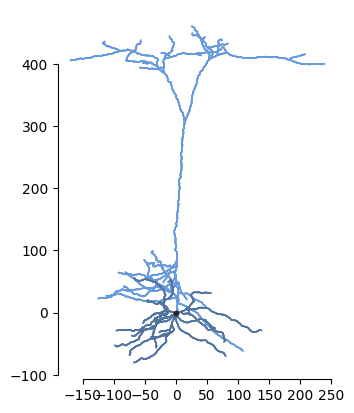

In [43]:
plot_neuron(neighbors, features)